<a href="https://colab.research.google.com/github/JinkyoHan/PINN_Elastic_Plate/blob/main/FvK_PDE_042.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PINNs + FvK Equation

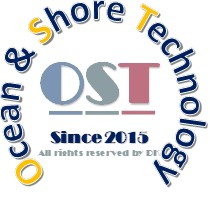



# **V. 0.4.2**

Implemented by Jinkyo Han
38jinkyo@snu.ac.kr

---

# References

- Li, W., Bazant, M. Z., & Zhu, J. (2021). A physics-guided neural network framework for elastic plates: Comparison of governing equations-based and energy-based approaches. Computer Methods in Applied Mechanics and Engineering, 383, 113933.

 https://github.com/weili101/Deep_Plates

- Yu, B. (2018). The deep Ritz method: a deep learning-based numerical algorithm for solving variational problems. Communications in Mathematics and Statistics, 6(1), 1-12.

- Sirignano, J., & Spiliopoulos, K. (2018). DGM: A deep learning algorithm for solving partial differential equations. Journal of computational physics, 375, 1339-1364.

- Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2019). Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations. Journal of Computational physics, 378, 686-707.

- Karniadakis, G. E., Kevrekidis, I. G., Lu, L., Perdikaris, P., Wang, S., & Yang, L. (2021). Physics-informed machine learning. Nature Reviews Physics, 3(6), 422-440.

- Panda, S. K., & Ramachandra, L. S. (2010). Buckling of rectangular plates with various boundary conditions loaded by non-uniform inplane loads. International Journal of Mechanical Sciences, 52(6), 819-828.

- Dym, Clive L., and Irving Herman Shames. Solid mechanics. New York, NY, USA:: McGraw-Hill, 1973.

- Landau, L. D., Lifshitz, E. M., Kosevich, A. M., & Pitaevskii, L. P. (1986). Theory of elasticity: volume 7 (Vol. 7). Elsevier.

- Bastek, J. H., & Kochmann, D. M. (2023). Physics-informed neural networks for shell structures. European Journal of Mechanics-A/Solids, 97, 104849.

  https://github.com/jhbastek/PhysicsInformedShellStructures

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from torch.optim.lr_scheduler import StepLR

In [38]:
class Net(nn.Module):

    def __init__(self, n_input, n_output, n_layer, n_nodes):
        super(Net, self).__init__()
        self.n_layer = n_layer

        self.Input = nn.Linear(n_input, n_nodes)
        nn.init.xavier_uniform_(self.Input.weight)
        nn.init.normal_(self.Input.bias)

        self.Output = nn.Linear(n_nodes, n_output)
        nn.init.xavier_uniform_(self.Output.weight)
        nn.init.normal_(self.Output.bias)

        self.Hidden = nn.ModuleList()
        for i in range(n_layer):
            self.Hidden.append(nn.Linear(n_nodes, n_nodes))
        for layer in self.Hidden:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.normal_(layer.bias)


    def forward(self, x):
        y = torch.tanh(self.Input(x))
        for layer in self.Hidden:
            y = torch.tanh(layer(y))
        y = self.Output(y)
        return y

In [39]:
# Problem Statements

E = 205900 # N/mm^2 or GPa
mu = 0.3

h = 10 # mm
q = 0 # N/mm^2
a = 1000 # mm
b = 1000 # mm

N_cr = 74.438 # N/mm
N_xx_given = N_cr * 1.0 # N/m

D = E*h**3/(1-mu**2)/12.
C = E*h/(1 - mu**2)


# Shape Functions
func_u1 = lambda x: (x[:,0])*(x[:,0]-1)*(x[:,0]+1)
func_u2 = lambda x: (x[:,0])

func_v1 = lambda x: (x[:,1])*(x[:,1]-1)*(x[:,1]+1)
func_v2 = lambda x: (x[:,1])

func_w = lambda x: (x[:,0]+1)*(x[:,0]-1)*(x[:,1]+1)*(x[:,1]-1)

# Constant Parameter: "Trainable"
constant_u2 = torch.nn.Parameter(torch.tensor([0.0]))
constant_v2 = torch.nn.Parameter(torch.tensor([0.0]))

# Definre Neural Networks
Net_w  = Net(2, 1, 10, 10)
Net_u1 = Net(2, 1, 10, 10)
Net_v1 = Net(2, 1, 10, 10)

In [40]:
def derivatives_1(x, w):

    dw_xy = torch.autograd.grad(w, x, torch.ones_like(w), retain_graph=True,
    create_graph=True, allow_unused=True)
    dw_x = dw_xy[0][:,0].view(-1,1)
    dw_y = dw_xy[0][:,1].view(-1,1)

    return dw_x, dw_y

In [41]:
def derivatives_2(x, w):

    dw_xy = torch.autograd.grad(w, x, torch.ones_like(w), retain_graph=True,
    create_graph=True, allow_unused=True)
    dw_x = dw_xy[0][:,0].view(-1,1)
    dw_y = dw_xy[0][:,1].view(-1,1)

    # second partial derivative
    dw_xxy = torch.autograd.grad(dw_x, x, torch.ones_like(dw_x), retain_graph=True,
    create_graph=True,allow_unused=True)
    dw_xx = dw_xxy[0][:,0].view(-1,1)
    dw_xy = dw_xxy[0][:,1].view(-1,1)
    dw_yy = torch.autograd.grad(dw_y, x, torch.ones_like(dw_y), retain_graph=True,
    create_graph=True,allow_unused=True)[0][:,1].view(-1,1)

    return dw_x, dw_y, dw_xx, dw_yy, dw_xy

# Strain Fields

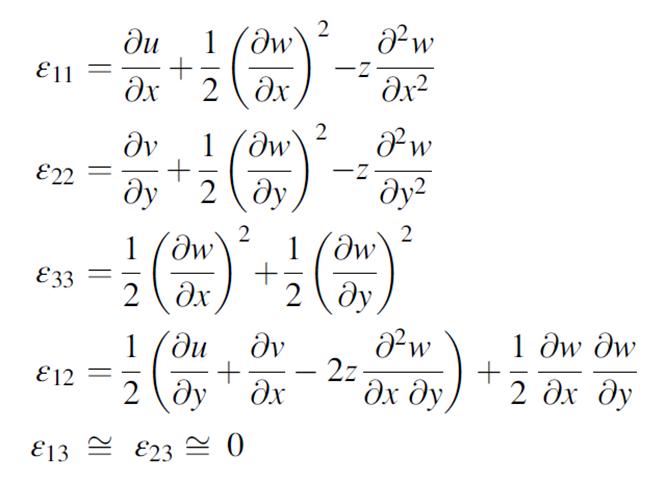

# Resultants

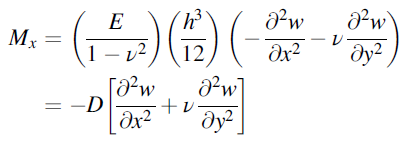

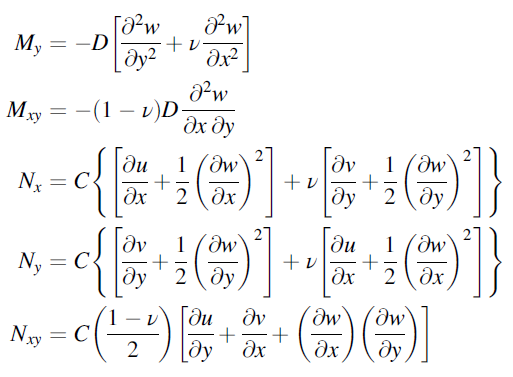

# Governing Equation & BC

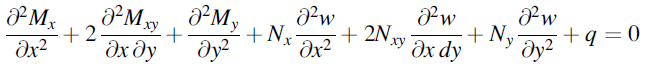

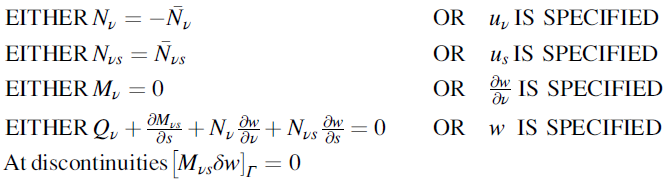

# Total Potential Energy
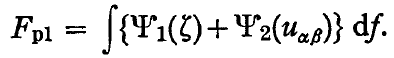

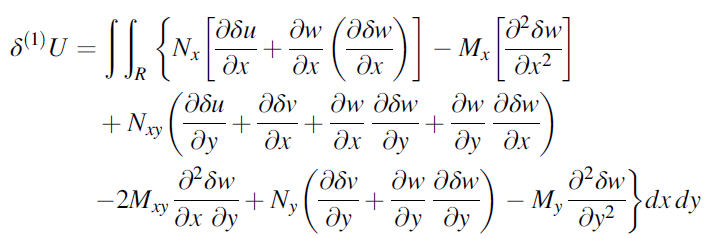


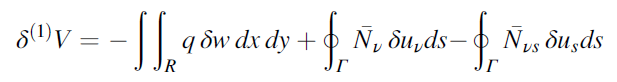

In [42]:
def Energy_density(x, u, v, w):

    # Calculate Derivatives
    dw_x, dw_y, dw_xx, dw_yy, dw_xy = derivatives_2(x, w)
    du_x, du_y = derivatives_1(x, u)
    dv_x, dv_y = derivatives_1(x, v)

    # Dimensionalize parameters
    w, u, v = w*h, u*a, v*b
    dw_x, dw_y = dw_x*h/a, dw_y*h/b
    du_x, du_y = du_x*a/a, du_y*a/b
    dv_x, dv_y = dw_x*b/a, dw_y*b/b
    dw_xx, dw_yy, dw_xy = dw_xx*h/a**2, dw_yy*h/b**2, dw_xy*h/a/b

    s11 = du_x + 0.5 * dw_x**2
    s22 = dv_y + 0.5 * dw_y**2
    s12 = 0.5 * (du_y + dv_x + dw_x*dw_y)
    #s33 = 0.5 * (dw_x**2 + dw_y**2)

    b11 = dw_xx
    b22 = dw_yy
    b12 = 2 * dw_xy

    N_xx = C*(s11 + mu*s22)
    N_yy = C*(s22 + mu*s11)
    N_xy = C*(1 - mu)*s12

    M_xx = -D*(b11 + mu*b22)
    M_yy = -D*(b22 + mu*b11)
    M_xy = -(1 - mu)*D*b12 / 2

    # Strain Energy per area : unit = N / mm
    U_m = (s11*N_xx + s22*N_yy + 2*s12*N_xy)
    U_b = - (b11*M_xx + b22*M_yy + 2*b12*M_xy)

    # External Energy per length : unit = N/mm
    U_e = u[x[:,0]==1]*N_xx_given/a - u[x[:,0]==-1]*N_xx_given/a

    '''
    # Penalty Term for Boundary Condition : unit = N/mm
    BC_v  = (N_xx[x[:,0]== -1] + N_xx_given).abs()
    BC_v += (N_xx[x[:,0]==  1] + N_xx_given).abs()
    BC_v += (N_yy[x[:,1]== -1]).abs()
    BC_v += (N_yy[x[:,1]==  1]).abs()

    BC_s  = (N_xy[x[:,0]== -1]).abs()
    BC_s += (N_xy[x[:,0]==  1]).abs()
    BC_s += (N_xy[x[:,1]== -1]).abs()
    BC_s += (N_xy[x[:,1]==  1]).abs()

    BC_m  = (M_xx[x[:,1]== -1]/h).abs()
    BC_m += (M_xx[x[:,1]==  1]/h).abs()
    BC_m += (M_yy[x[:,0]== -1]/h).abs()
    BC_m += (M_yy[x[:,0]==  1]/h).abs()

    BC = BC_v + BC_s + BC_m
    '''

    return torch.mean(U_m), torch.mean(U_b), torch.mean(U_e)#, torch.mean(BC)

In [43]:
def train_data(Nx, Ny, Nf):
    x = np.linspace(-1, 1, Nx).reshape([Nx, 1])
    y = np.linspace(-1, 1, Ny).reshape([Ny, 1])

    # Points at Boundary
    Xb = np.vstack([np.hstack([x, np.full_like(x, -1)]),  # lower
                    np.hstack([x, np.full_like(x, 1)]),   # upper
                    np.hstack([np.full_like(y, -1), y]),  # left
                    np.hstack([np.full_like(y, 1), y])])  # right
    Xb = np.unique(Xb, axis=0)
    Xf1 = torch.tensor(Xb, dtype=torch.float32, requires_grad=True)

    # Points inside domain
    while True:
        Xf2 = np.random.rand(Nf, 2) * 2 - 1
        # eliminate points at boundary
        Xf2 = Xf2[~((np.isclose(Xf2[:, 0], -1) | np.isclose(Xf2[:, 0], 1)) |
                    (np.isclose(Xf2[:, 1], -1) | np.isclose(Xf2[:, 1], 1)))]
        if len(Xf2) >= Nf:
            break
    Xf2 = Xf2[:Nf]
    Xf2 = torch.tensor(Xf2, dtype=torch.float32, requires_grad=True)

    return Xf1, Xf2


def train_data_grid(Nx, Ny):
    # Generate x and y coordinates
    x = np.linspace(-1, 1, Nx)
    y = np.linspace(-1, 1, Ny)

    # Use meshgrid to generate grid points
    X, Y = np.meshgrid(x, y)

    # Transform grid points into (N, 2) shape
    Xf = np.vstack([X.ravel(), Y.ravel()]).T

    # Convert to PyTorch tensor
    Xf = torch.tensor(Xf, dtype=torch.float32, requires_grad=True)

    return Xf


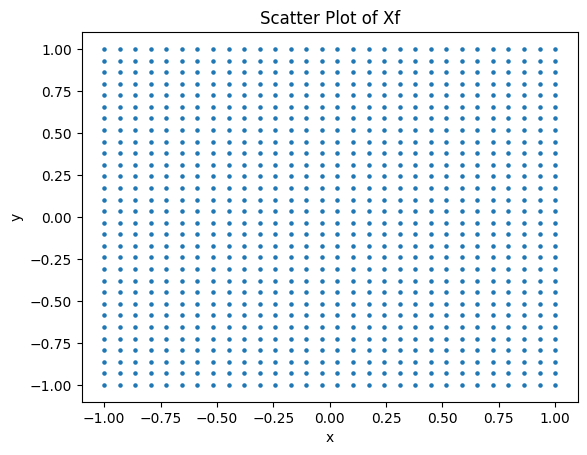

In [44]:
# Prepare training data
Nx1 = 100
Ny1 = 100

Xf = train_data_grid(30,30)

Xf_np = Xf.detach().numpy()

# Plot scattered diagram
plt.scatter(Xf_np[:, 0], Xf_np[:, 1], s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter Plot of Xf')
plt.show()

In [45]:
# Pretraining the neural network to fit initial mode

nepoches = 1000
learning_rate = 2e-3
optimizer = torch.optim.Adam(
    list(Net_w.parameters()) +
    list(Net_u1.parameters()) +
    list(Net_v1.parameters()) +
    [constant_u2, constant_v2],  # with Constant Optimization
    lr=learning_rate
)

for epoch in range(nepoches):

    w = Net_w(Xf) * (func_w(Xf).view(-1, 1))
    u = Net_u1(Xf) * (func_u1(Xf).view(-1, 1)) + constant_u2 * (func_u2(Xf).view(-1, 1))
    v = Net_v1(Xf) * (func_v1(Xf).view(-1, 1)) + constant_v2 * (func_v2(Xf).view(-1, 1))

    loss1 = w - func_w(Xf).view(-1,1)
    loss2 = u + 0.1*(Xf[:,0]).view(-1,1)
    loss3 = v - 0.1*(Xf[:,1]).view(-1,1)

    loss = torch.mean(loss1)**2+torch.mean(loss2)**2+torch.mean(loss3)**2

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if (epoch+1) % 100 == 0:
        print(f'epoch:{epoch+1}, Total:{loss:.4e}')

epoch:100, Total:8.2028e-06
epoch:200, Total:9.7091e-10
epoch:300, Total:3.9167e-16
epoch:400, Total:1.2436e-16
epoch:500, Total:2.8290e-17
epoch:600, Total:1.2561e-17
epoch:700, Total:3.5456e-18
epoch:800, Total:1.9424e-18
epoch:900, Total:1.6631e-18
epoch:1000, Total:2.1553e-18


In [47]:
# Prepare training data
Nx1 = 30
Ny1 = 30
Nf1 = 8100

Xf1, Xf2 = train_data(Nx1, Ny1, Nf1)
Xf = torch.cat([Xf1, Xf2], dim=0)

nepochs = 60000  # Number of epochs for training
learning_rate = 1e-2  # Initial learning rate
best_loss = float('inf')  # Initialize best loss to infinity
loss_history = []  # To keep track of loss over time

# Define the optimizer with parameters from multiple networks and constant parameters
optimizer = torch.optim.Adam(
    list(Net_w.parameters()) +
    list(Net_u1.parameters()) +
    list(Net_v1.parameters()) +
    [constant_u2, constant_v2],  # Adding constant parameters
    lr=learning_rate
)

patience = 1000  # Maximum number of epochs to wait for improvement in loss
patience_counter = 0  # Counter for epochs without improvement in loss

for epoch in range(nepochs):

    w = Net_w(Xf) * (func_w(Xf).view(-1, 1))
    u = Net_u1(Xf) * (func_u1(Xf).view(-1, 1)) + constant_u2 * (func_u2(Xf).view(-1, 1))
    v = Net_v1(Xf) * (func_v1(Xf).view(-1, 1)) + constant_v2 * (func_v2(Xf).view(-1, 1))

    U_m, U_b, U_e = Energy_density(Xf, u, v, w)

    loss = (U_m + U_b) + U_e
    loss = loss**2

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Save current loss and update best loss
    current_loss = loss.item()
    loss_history.append(current_loss)

    if current_loss < best_loss:
        best_loss = current_loss
        patience_counter = 0  # Reset counter when there is an improvement
        torch.save({'Net_w_state_dict': Net_w.state_dict(),
                    'Net_u1_state_dict': Net_u1.state_dict(),
                    'Net_v1_state_dict': Net_v1.state_dict(),
                    'constant_u2': constant_u2,
                    'constant_v2': constant_v2},
                   'best_model.pth')
    else:
        patience_counter += 1

    # Learning rate adjustment logic
    if patience_counter >= patience:
        patience_counter = 0  # Reset counter
        for param_group in optimizer.param_groups:
            param_group['lr'] /= 3
        print(f"Learning rate adjusted at epoch {epoch+1}, to {param_group['lr']}")

    # Sampling logic remains the same
    Xf1, Xf2 = train_data(Nx1, Ny1, Nf1)
    Xf = torch.cat([Xf1, Xf2], dim=0)

    if (epoch+1) % 100 == 0:
        print(f'epoch:{epoch+1}, Total loss:{loss:.4e}, Membrane:{U_m:.4e}, Bending:{U_b:.4e}, External:{U_e:.4e}')


epoch:100, Total loss:1.6946e+04, Membrane:1.3130e+02, Bending:2.0628e-04, External:-1.1240e+00
epoch:200, Total loss:7.7209e+03, Membrane:8.8796e+01, Bending:8.3416e-05, External:-9.2765e-01
epoch:300, Total loss:3.7344e+03, Membrane:6.1886e+01, Bending:3.0865e-05, External:-7.7616e-01
epoch:400, Total loss:1.9976e+03, Membrane:4.5360e+01, Bending:9.6251e-06, External:-6.6571e-01
epoch:500, Total loss:1.1662e+03, Membrane:3.4732e+01, Bending:2.9311e-06, External:-5.8288e-01
epoch:600, Total loss:7.2724e+02, Membrane:2.7486e+01, Bending:9.5406e-07, External:-5.1871e-01
epoch:700, Total loss:4.7850e+02, Membrane:2.2342e+01, Bending:3.6960e-07, External:-4.6754e-01
epoch:800, Total loss:3.2775e+02, Membrane:1.8530e+01, Bending:1.5976e-07, External:-4.2576e-01
epoch:900, Total loss:2.3214e+02, Membrane:1.5627e+01, Bending:8.7268e-08, External:-3.9095e-01
epoch:1000, Total loss:1.6888e+02, Membrane:1.3357e+01, Bending:5.8241e-08, External:-3.6147e-01
epoch:1100, Total loss:1.2590e+02, Memb

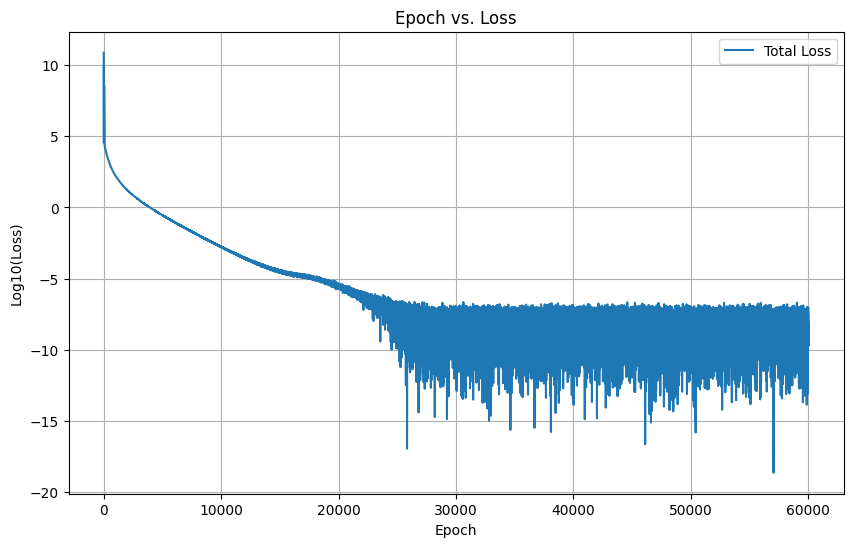

In [48]:
# Load Best Model State
checkpoint = torch.load('best_model.pth')
Net_w.load_state_dict(checkpoint['Net_w_state_dict'])
Net_u1.load_state_dict(checkpoint['Net_u1_state_dict'])
Net_v1.load_state_dict(checkpoint['Net_v1_state_dict'])
constant_u2 = checkpoint['constant_u2']
constant_v2 = checkpoint['constant_v2']

# Plot for Loss-Epoch
plt.figure(figsize=(10, 6))
plt.plot(np.log10(loss_history), label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Log10(Loss)')
plt.title('Epoch vs. Loss')
plt.legend()
plt.grid(True)
plt.show()


In [49]:
x = np.linspace(-1,1,120).reshape([120,1])
y = np.linspace(-1,1,120).reshape([120,1])
X, Y = np.meshgrid(x, y)
Xf = np.vstack([X.ravel(), Y.ravel()]).T
Xf = torch.tensor(Xf, dtype=torch.float32, requires_grad=True)

# Correctly use Xf in calculations
w = Net_w(Xf) * (func_w(Xf).view(-1, 1))
u = Net_u1(Xf) * (func_u1(Xf).view(-1, 1)) + constant_u2 * (func_u2(Xf).view(-1, 1))
v = Net_v1(Xf) * (func_v1(Xf).view(-1, 1)) + constant_v2 * (func_v2(Xf).view(-1, 1))

# Calculate Derivatives
dw_x, dw_y, dw_xx, dw_yy, dw_xy = derivatives_2(Xf, w)
du_x, du_y, du_xx, du_yy, du_xy = derivatives_2(Xf, u)
dv_x, dv_y, dv_xx, dv_yy, dv_xy = derivatives_2(Xf, v)

# Dimensionalize parameters
w, u, v = w*h, u*a, v*b
dw_x, dw_y = dw_x*h/a, dw_y*h/b
du_x, du_y = du_x*a/a, du_y*a/b
dv_x, dv_y = dw_x*b/a, dw_y*b/b
dw_xx, dw_yy, dw_xy = dw_xx*h/a**2, dw_yy*h/b**2, dw_xy*h/a/b
du_xx, du_yy, du_xy = du_xx*a/a**2, du_yy*a/b**2, du_xy*a/a/b
dv_xx, dw_yy, dw_xy = dv_xx*b/a**2, dv_yy*b/b**2, dv_xy*b/a/b

# Force Resultants
N_xx = C*((du_x+0.5*dw_x**2) + mu*(dv_y+0.5*dw_y**2))
N_yy = C*((dv_y+0.5*dw_y**2) + mu*(du_x+0.5*dw_x**2))
N_xy = C*(1 - mu)*0.5*(du_y+dv_x+dw_x*dw_y)
print(N_xx[Xf[:,0]==1].mean())
print(N_xx[Xf[:,0]==-1].mean())

M_xx = -D*(dw_xx+mu*dw_yy)
M_yy = -D*(dw_yy+mu*dw_xx)
M_xy = -D*(1 - mu)*dw_xy

X = Xf[:,0].detach().numpy().reshape(-1,1)*a
Y = Xf[:,1].detach().numpy().reshape(-1,1)*b

W = w.detach().numpy().reshape(-1,1)
U = u.detach().numpy().reshape(-1,1)
V = v.detach().numpy().reshape(-1,1)

N_xx = N_xx.detach().numpy().reshape(-1,1)
N_yy = N_yy.detach().numpy().reshape(-1,1)
M_xx = M_xx.detach().numpy().reshape(-1,1)
M_yy = M_yy.detach().numpy().reshape(-1,1)

tensor(14.4705, grad_fn=<MeanBackward0>)
tensor(-272.0655, grad_fn=<MeanBackward0>)


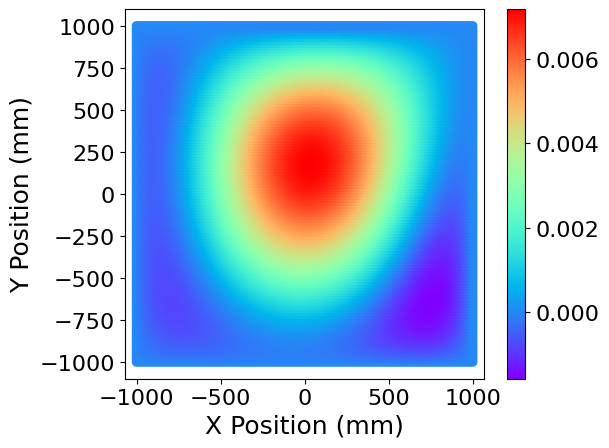

In [57]:
fig, ax = plt.subplots(figsize=(5.8, 4.8))

surf = ax.scatter(X, Y, c = W, cmap=cm.rainbow)

cb = fig.colorbar(surf)

cb.ax.tick_params(labelsize=16)

ax.axis('equal')
ax.set_xlabel('X Position (mm)', fontsize=18)
ax.set_ylabel('Y Position (mm)', fontsize=18)
for tick in ax.get_xticklabels():
    tick.set_fontsize(16)
for tick in ax.get_yticklabels():
    tick.set_fontsize(16)

plt.show()


In [51]:
X = X.reshape(120,120)
Y = Y.reshape(120,120)
W = W.reshape(120,120)
U = U.reshape(120,120)
V = V.reshape(120,120)

N_xx = N_xx.reshape(120,120)
N_yy = N_yy.reshape(120,120)
M_xx = M_xx.reshape(120,120)
M_yy = M_yy.reshape(120,120)

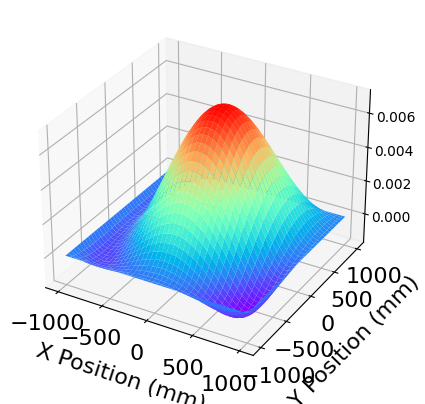

In [52]:
fig = plt.figure(figsize=(8, 4.8))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(X, Y, W, cmap=cm.rainbow)

cb.ax.tick_params(labelsize=16)

ax.set_xlabel('X Position (mm)', fontsize=16, labelpad=8)
ax.set_ylabel('Y Position (mm)', fontsize=16, labelpad=8)

for tick in ax.get_xticklabels():
    tick.set_fontsize(16)
for tick in ax.get_yticklabels():
    tick.set_fontsize(16)

plt.show()